In [6]:
import pandas as pd
import numpy as np

dir = "sc sensor/sc10_2/AgentActivities.log"
df = pd.read_table(dir, sep=';', header=0).dropna(axis=1, how='all')
# p = pd.read_table("raw_data/new_sc1/Rep1/AgentActivities.log", sep=';', header=0).dropna(axis=1, how='all')

In [2]:
df.head()

,AgentID,ActivityID,TimeIn,TimeOut,xLoc,yLoc,zLoc,TotalDelayTime,TotalDistance
0,57559,55,600.0000,632.4000,-17.2000,55.4000,6.0,0.0000,0.0000
1,57559,1,713.0000,713.0000,-0.3937,2.6017,0.0,3.8192,90.5042
2,76477,2,2844.0000,2844.0000,6.7101,116.6710,0.0,0.0000,0.0000
3,76477,8,3048.6001,3048.6001,15.3734,81.3419,6.0,105.0496,105.7310
4,55494,1,194.0000,194.0000,-11.2718,1.2188,0.0,0.0000,0.0000


In [2]:
def generate_od_series(dir):
    """
    generate od series from agent activity log
    """
    p = pd.read_table(dir, sep=';', header=0).dropna(axis=1, how='all')
    orign_tab = p.copy()
    # print(len(orign_tab))
    for id in [59, 62, 63, 64]:
        orign_tab = orign_tab.drop(index=orign_tab[orign_tab.ActivityID==id].index) # drop waiting activity

    # print(len(orign_tab))
    shift_tab = orign_tab.sort_values(by="TimeIn", ascending=True).groupby(by="AgentID")[["TimeIn", "ActivityID"]].shift(-1)
    orign_tab["NextTimeIn"] = shift_tab["TimeIn"]
    orign_tab["NextActivity"] = shift_tab["ActivityID"]
    orign_tab = orign_tab.dropna(subset=["NextActivity"]) # drop the last activity

    orign_tab["OD"] = orign_tab.apply(lambda row: "|".join([str(row.ActivityID), str(row.NextActivity)]), axis=1)
    od_series = orign_tab.groupby("OD").size()
    return od_series

In [3]:
# od = [1, 2, 8, 9, 10, 11, 12, 13, 14, 15] #entry exit
def generate_od_mat(od_series, mode='partial'):
    if mode == 'partial': #only include transportation
        od = [1, 2, 51, 52, 53, 54, 55, 56, 57, 58] #
    else: # include entry and exit
        od = [1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 51, 52, 53, 54, 55, 56, 57, 58] #entry exit
    od_mat = np.zeros([len(od), len(od)])
    for ind in od_series.index:
        o = int(float(ind.split('|')[0]))
        d = int(float(ind.split('|')[1]))
        if o in od and d in od:
            od_mat[od.index(o), od.index(d)] += od_series[ind]
    return od_mat

In [113]:
def plot_odmatrix(od_mat, file_label_name, save=False):
    """Plots the OD matrix with sorted labels, handling numerical strings."""
    try:
        # Attempt to convert labels to integers for numerical sorting
        sorted_labels = sorted(file_label_name, key=int)
    except ValueError:
        # If conversion fails (non-numerical strings), sort lexicographically
        sorted_labels = sorted(file_label_name)
    # Create a DataFrame with the original order for indexing
    df = pd.DataFrame(od_mat, index=file_label_name, columns=file_label_name)
    # Reindex the DataFrame using the sorted labels
    df_sorted = df.reindex(index=sorted_labels, columns=sorted_labels)
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1.5)
    sns.set_context({"figure.figsize":(8,8)})
    sns.heatmap(data=df_sorted, square=True)

    plt.xticks(np.arange(len(sorted_labels))+0.5, sorted_labels, rotation=90, fontsize=12)
    plt.yticks(np.arange(len(sorted_labels))+0.5, sorted_labels, rotation=0, fontsize=12)

    if save:
        plt.savefig("./fig/ssim_mat.pdf", bbox_inches='tight')
    plt.show()

In [4]:
import seaborn as sns
from sklearn import preprocessing
# def plot_odmatrix(od_mat, file_label_name, save=False):
#     min_max_scaler = preprocessing.MinMaxScaler()
#     plt.figure(figsize=(8, 8))
#     # data = (od_mat - od_mat.min(axis=0))/(od_mat.max(axis=0) - od_mat.min(axis=0))
#     # data = pd.DataFrame(data)
#     data = od_mat
#     sns.set(font_scale=1.5)
#     sns.set_context({"figure.figsize":(8,8)})
#     sns.heatmap(data=data,square=True)
#     plt.xticks(np.arange(len(file_label_name))+0.5, file_label_name, rotation=90, fontsize=10)
#     plt.yticks(np.arange(len(file_label_name))+0.5, file_label_name, rotation=0, fontsize=10)
#     if save:
#         plt.savefig("./fig/ssim_mat.pdf", bbox_inches='tight')

In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def plot_odgraph(od_data, sc, save=False, transp=True):
    """
    Generate a graph from OD data

    Args:
        od_data (ndarray): 2D OD matrix
        save (bool, optional): Whether to save the graph as a PDF file. Defaults to False.
    """
    # Create a list of node names
    nodes = ['Back', 'Main', 'Plt1', 'Plt2', 'Plt3', 'Plt4', 'Plt5', 'Plt6', 'Plt7', 'Plt8']

    # Create a directed graph
    graph = nx.DiGraph()

    # Add nodes to the graph
    graph.add_nodes_from(nodes)

    # Add edges to the graph
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            flow = od_data[i, j]
            if flow > 0:
                graph.add_edge(nodes[i], nodes[j], flow=int(flow))

    # Set node positions for better visualization
    pos = nx.circular_layout(graph)

    # Extract flow values from edge attributes
    flows = [flow for _, _, flow in graph.edges.data('flow')]

    # Define the thickness of edges based on flow values
    min_thickness = 0  # Minimum thickness
    max_thickness = 10  # Maximum thickness
    edge_thickness = [min_thickness + (max_thickness - min_thickness) * (flow / 500) for flow in flows]  # 500 is the maximum flow value in the dataset

    # Define the transparency of edges based on flow values
    if transp:
        min_alpha = 0  # Minimum transparency
        max_alpha = 1.0  # Maximum transparency
        edge_alpha = [min_alpha + (max_alpha - min_alpha) * (flow / 350) for flow in flows]  # 500 is the maximum flow value in the dataset
    else:
        edge_alpha = [1 for _ in range(len(flows))]
    # Create a colormap for assigning different colors based on source node index
    num_nodes = len(nodes)
    cmap = plt.get_cmap('tab10')

    # Create the figure with adjusted size
    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw nodes
    outflow = od_data.sum(axis=1)
    min_thickness = 200
    max_thickness = 500
    node_size_list = [min_thickness + (max_thickness - min_thickness) * outflow[i]/1000 for i in range(len(outflow))]
    for i, node in enumerate(nodes):
        color = cmap(nodes.index(node) % num_nodes)
        nx.draw_networkx_nodes(graph, pos, nodelist=[node], node_color=np.array([color]), node_size=node_size_list[i])
    # nx.draw_networkx_nodes(graph, pos, node_color='lightblue', node_size=500)

    # Filter edges with flow > 0
    non_zero_edges = [(u, v) for u, v, flow in graph.edges.data('flow') if flow > 0]

    # Draw curved edges with thickness based on flow values
    for i, (u, v) in enumerate(non_zero_edges):
        color = cmap(nodes.index(u) % num_nodes)
        nx.draw_networkx_edges(
            graph,
            pos,
            edgelist=[(u, v)],
            arrows=True,
            width=edge_thickness[i],
            edge_color=color,
            alpha=min(edge_alpha[i], 1),
            connectionstyle="arc3,rad=0.1"  # Adjust the curvature by modifying the `rad` parameter
        )

    # Draw edge labels (flow values)
    # edge_labels = nx.get_edge_attributes(graph, 'flow')
    # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='black')
    edge_labels = {}
    edges_to_label = [("Main", "Plt1"), ("Main", "Plt2"), ("Main", "Plt3"),
                      ("Main", "Plt4"), ("Main", "Plt5"), ("Main", "Plt6"),
                      ("Main", "Plt7"), ("Main", "Plt8"), ("Plt1", "Plt2"),
                      ("Plt2", "Plt3"), ("Plt3", "Plt4"), ("Plt4", "Plt5"),
                      ("Plt5", "Plt6"), ("Plt6", "Plt7"), ("Plt7", "Plt8"),
                      ("Main", "Back")]
    for u, v, flow in graph.edges.data('flow'):
        if (u, v) in edges_to_label:
            edge_labels[(u, v)] = flow
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='black')


    # Draw node labels
    node_labels = {node: node for node in graph.nodes}
    nx.draw_networkx_labels(graph, pos, labels=node_labels)

    if save:
        plt.savefig(f"./fig/od_graph_{sc}.pdf", bbox_inches='tight', transparent=True)

    # Set axis off
    plt.axis('off')

    # Add a title
    plt.title('OD Graph')

    # Display the graph
    plt.show()

    return graph


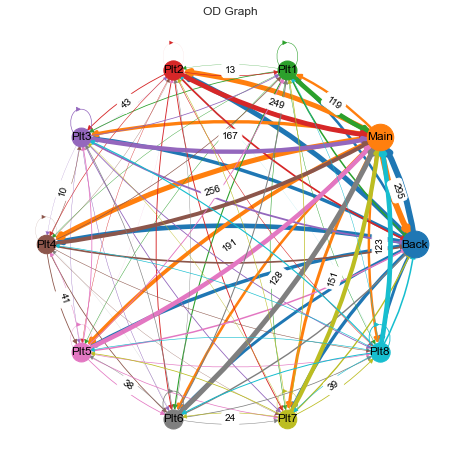

In [9]:
dir = "sc sensor 2/sc18/AgentActivities.log"
od_series = generate_od_series(dir)
od_mat = generate_od_mat(od_series)
graph = plot_odgraph(od_mat, sc="sc11", save=False, transp=False)
# OD_Series.index

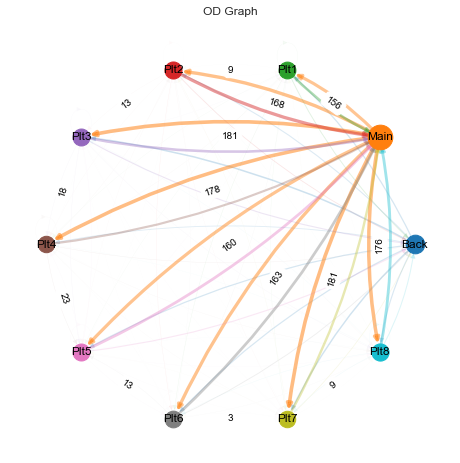

In [7]:
dir = "sc sensor/sc4/AgentActivities.log"
od_series = generate_od_series(dir)
od_mat4 = generate_od_mat(od_series)
graph = plot_odgraph(od_mat4, sc="sc11", save=False)
# OD_Series.index

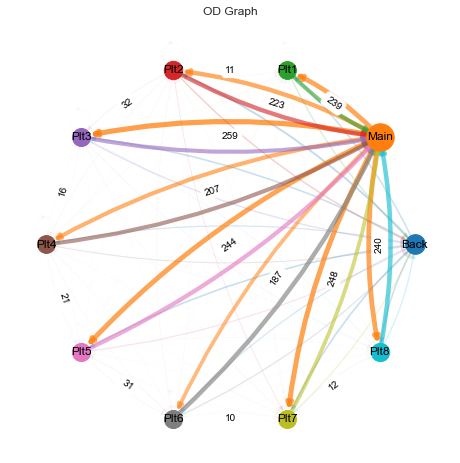

In [8]:
dir = "sc sensor/sc4_2/AgentActivities.log"
od_series = generate_od_series(dir)
od_mat2 = generate_od_mat(od_series)
graph = plot_odgraph(od_mat2, sc="sc9", save=False)

In [96]:
from skimage.metrics import structural_similarity as ssim
ssim(od_mat4, od_mat2, data_range=800)

0.6620598553790247

In [97]:
od_mat4 = (od_mat4 - od_mat4.mean())/od_mat4.std()
od_mat2 = (od_mat2 - od_mat2.mean())/od_mat2.std()

# od_mat4 = (od_mat4 - od_mat4.min())/(od_mat4.max() - od_mat4.min())
# od_mat2 = (od_mat2 - od_mat2.min())/(od_mat2.max() - od_mat2.min())
data_min = min(np.min(od_mat4), np.min(od_mat2))
data_max = max(np.max(od_mat4), np.max(od_mat2))
data_range = data_max - data_min
round(ssim(od_mat4, od_mat2, data_range=data_range), 3)

0.572

In [20]:
"""
    SSIM for each scenarios. first visualize method.
"""
from skimage.metrics import structural_similarity as ssim
import os
ssim_eva = []
ssim_normal = []
normal_od_mat = generate_od_mat(generate_od_series("sc sensor/sc3/AgentActivities.log"))
eva_od_mat = generate_od_mat(generate_od_series("sc sensor/sc11/AgentActivities.log"))
file_label_name = []
data_range = 800
for file_name in os.listdir("sc sensor"):
    if  file_name == ".DS_Store":
        continue
    dir = "sc sensor/" + file_name + "/AgentActivities.log"
    # od_series = generate_od_series(dir)
    # od_mat = generate_od_mat(od_series)
    # ssim_normal.append(ssim(od_mat, normal_od_mat, data_range=data_range))
    # ssim_eva.append(ssim(od_mat, eva_od_mat, data_range=data_range))
    file_label_name.append(file_name[2:])

for file_name in os.listdir("sc sensor 2"):
    if file_name == ".DS_Store":
        continue
    dir = "sc sensor 2/" + file_name + "/AgentActivities.log"
    # od_series = generate_od_series(dir)
    # od_mat = generate_od_mat(od_series)
    # ssim_normal.append(ssim(od_mat, normal_od_mat, data_range=data_range))
    # ssim_eva.append(ssim(od_mat, eva_od_mat, data_range=data_range))
    file_label_name.append(file_name[2:])


In [10]:
"""
Compare scenarios with SSIM.
"""
import os
def generate_ssim_mat(normalize=False):
    """
    Generate a matrix of SSIM for each scenario.
    """
    od_mat_list = []

    for file_name in os.listdir("sc sensor"):
        if  file_name == ".DS_Store":
            continue
        dir = "sc sensor/" + file_name + "/AgentActivities.log"
        od_series = generate_od_series(dir)
        od_mat = generate_od_mat(od_series)
        if normalize:
            # od_mat = (od_mat - od_mat.mean())/od_mat.std()
            pass
        od_mat_list.append(od_mat)

    for file_name in os.listdir("sc sensor 2"):
        if  file_name == ".DS_Store":
            continue
        dir = "sc sensor 2/" + file_name + "/AgentActivities.log"
        od_series = generate_od_series(dir)
        od_mat = generate_od_mat(od_series)
        if normalize:
            # od_mat = (od_mat - od_mat.mean())/od_mat.std()
            pass
        od_mat_list.append(od_mat)

    ssim_mat = np.zeros((len(od_mat_list), len(od_mat_list)))
    for i in range(len(od_mat_list)):
        for j in range(len(od_mat_list)):
            if normalize:
                # od_mat4 = (od_mat4 - od_mat4.min())/(od_mat4.max() - od_mat4.min())
                # od_mat2 = (od_mat2 - od_mat2.min())/(od_mat2.max() - od_mat2.min())
                data_min = min(np.min(od_mat_list[i]), np.min(od_mat_list[j])) # should use the data range
                data_max = max(np.max(od_mat_list[i]), np.max(od_mat_list[j]))
                data_range = data_max - data_min
                ssim_mat[i,j] = round(ssim(od_mat_list[i], od_mat_list[j], data_range=data_range), 3)
            else:
                ssim_mat[i,j] = round(ssim(od_mat_list[i], od_mat_list[j], data_range=800), 3)
    return ssim_mat

corr_mat = generate_ssim_mat(normalize=False)

In [69]:
len(file_label_name)

35

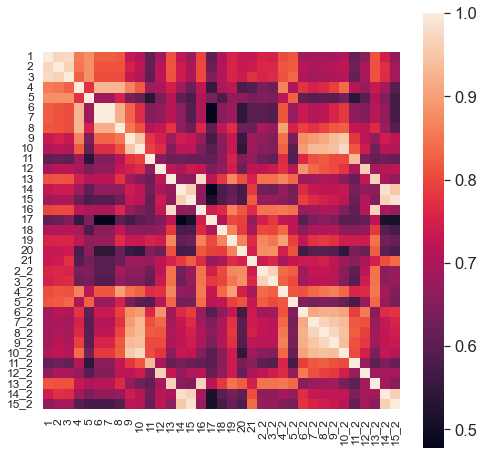

In [115]:
# plot_odmatrix(corr_mat[:,np.where([dend == 3])[1]])
plot_odmatrix(corr_mat, file_label_name, save=False) # not normalized, not data range

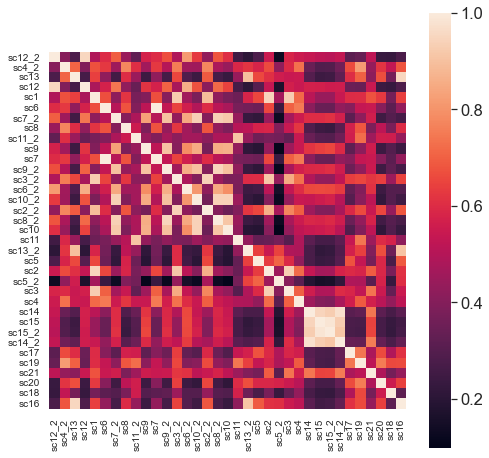

In [73]:
plot_odmatrix(corr_mat, file_label_name, save=False) # normalized

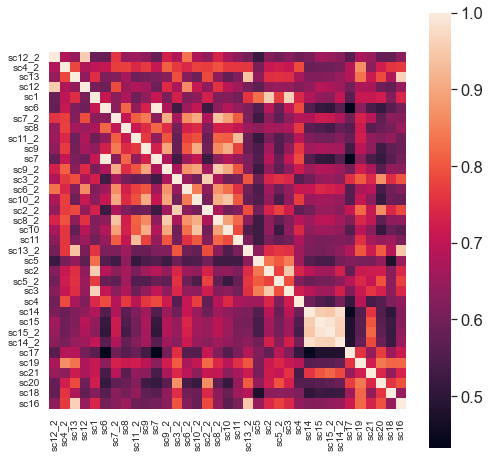

In [84]:
plot_odmatrix(corr_mat, file_label_name, save=False) # data range

In [26]:
name_dict = {}
for i, name in enumerate(file_label_name):
    name_dict[name] = i
print(name_dict)

{'sc12_2': 0, 'sc4_2': 1, 'sc13': 2, 'sc12': 3, 'sc1': 4, 'sc6': 5, 'sc7_2': 6, 'sc8': 7, 'sc11_2': 8, 'sc9': 9, 'sc7': 10, 'sc9_2': 11, 'sc3_2': 12, 'sc6_2': 13, 'sc10_2': 14, 'sc2_2': 15, 'sc8_2': 16, 'sc10': 17, 'sc11': 18, 'sc13_2': 19, 'sc5': 20, 'sc2': 21, 'sc5_2': 22, 'sc3': 23, 'sc4': 24, 'sc14': 25, 'sc15': 26, 'sc15_2': 27, 'sc14_2': 28, 'sc17': 29, 'sc19': 30, 'sc21': 31, 'sc20': 32, 'sc18': 33, 'sc16': 34}


In [27]:
"""
    Plot scenarios SSIM.
"""

def plot_scenarios(ssim_normal, ssim_eva, file_label_name):
    sns.set(font_scale=1.5)
    sns.set_context({"figure.figsize":(8,8)})
    plt.plot(ssim_normal, ssim_eva, 'o', markersize=15)
    plt.xlabel("SSIM of normal scenario")
    plt.ylabel("SSIM of evacuation scenario")
    for i, txt in enumerate(file_label_name):
        plt.annotate(txt, (ssim_normal[i], ssim_eva[i]), fontsize=10)
    plt.show()


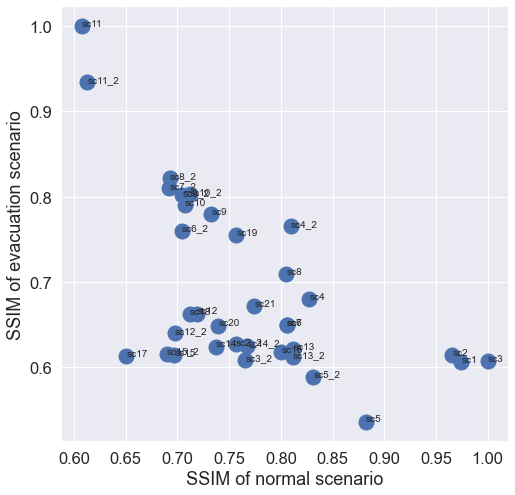

In [28]:
plot_scenarios(ssim_normal, ssim_eva, file_label_name)

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
# Perform hierarchical clustering
def plot_dendrogram(linkage_matrix, file_label_name):
    # Plot the dendrogram
    plt.figure(figsize=(10, 8))
    dendrogram(linkage_matrix, labels=file_label_name, orientation='right', leaf_font_size=13)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Distance')
    plt.ylabel('Scenarios')
    plt.show()

In [160]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

def visualize_clusters(similarity_matrix, file_label_name, n_clusters=0, mode="dbcsan", save=False):
    plt.figure(figsize=(8, 8))
    # Perform PCA on the similarity matrix
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(similarity_matrix)

    # Perform hierarchical clustering on the reduction data
    if mode == "dend":
        linkage_matrix = linkage(reduced_data, method='average', metric='euclidean')
        cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

    # Perform dbscan clustering on the reduction data
    elif mode == "dbscan":
        eps = 0.2  # Set the maximum distance between samples within a cluster
        min_samples = 2  # Set the minimum number of samples in a neighborhood to form a core point
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(reduced_data)

    else:
        pass
        # raise ValueError("mode should be either 'dend' or 'dbscan'")

    # Plot the reduced data with colored clusters
    training_sc = ["1", "2", "2_2", "3", "4", "4_2", "5", "13", "18", "19"]
    abnormal_list = ["8", "8_2", "9", "9_2", "12", "12_2", "21"]
    evac_list = ["11", "11_2", "10", "10_2", "14", "14_2", "20"]
    ab_index = list(map(lambda x: file_label_name.index(x) if x in file_label_name else None, abnormal_list))
    norml_list = list(set(file_label_name) - (set(abnormal_list + evac_list)))
    norml_index = list(map(lambda x: file_label_name.index(x) if x in file_label_name else None, norml_list))
    evac_index = list(map(lambda x: file_label_name.index(x) if x in file_label_name else None, evac_list))


    # legend_elements = [plt.scatter(reduced_data[norml_index, 0], reduced_data[norml_index, 1],
    #                         c="w", cmap='tab20', marker="o", edgecolors="black", alpha=0.5, label="Normal Scenarios", s=200),
    #                   plt.scatter(reduced_data[ab_index, 0], reduced_data[ab_index, 1],
    #                         c="w", cmap='tab20', marker="s", edgecolors="black", alpha=0.5, label="Abnormal Scenarios", s=200),
    #                   plt.scatter(reduced_data[evac_index, 0], reduced_data[evac_index, 1],
    #                         c="w", cmap='tab20', marker="^", edgecolors="black", alpha=0.5, label="Evacuation Scenarios", s=200)]
    # plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label=file_label_name, s=80, cmap='tab20', c=cluster_labels)
    # plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label=file_label_name, s=200, cmap='tab20')
    legend_elements = [plt.scatter(reduced_data[norml_index, 0], reduced_data[norml_index, 1],
                            c="r", cmap='tab20', marker="o", alpha=0.5, label="Normal Scenarios", s=200),
    plt.scatter(reduced_data[ab_index, 0], reduced_data[ab_index, 1],
                            c="g", cmap='tab20', marker="s", alpha=0.5, label="Abnormal Scenarios", s=200),
    plt.scatter(reduced_data[evac_index, 0], reduced_data[evac_index, 1],
                            c="b", cmap='tab20', marker="^", alpha=0.5, label="Evacuation Scenarios", s=200)]

    # for i, txt in enumerate(file_label_name):
    #     plt.annotate(txt, (reduced_data[i, 0], reduced_data[i, 1]), fontsize=15)

    y_offset = -0  # Adjust this value to control the vertical offset
    x_offset = -0.05
    for i, txt in enumerate(file_label_name):
        if txt in training_sc + ["15", "15_2"]:
            if txt in ["7", "16"]:
                plt.annotate(txt, (reduced_data[i, 0] + x_offset, reduced_data[i, 1] + y_offset), fontsize=15) # Added ha for horizontal alignment
            else:
                plt.annotate(txt, (reduced_data[i, 0], reduced_data[i, 1] + y_offset), fontsize=15)

    plt.xlabel('Principal Component 1', fontsize=20)
    plt.ylabel('Principal Component 2', fontsize=20)
    plt.title('PCA on Similarity Matrix', fontsize=20)
    # legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Normal Scenarios', markerfacecolor='w', markersize=10,
    #                               markeredgecolor='black'),
    #                    plt.Line2D([0], [0], marker='s', color='w', label='Abnormal Scenarios', markerfacecolor='w', markersize=10,
    #                               markeredgecolor='black'),
    #                    plt.Line2D([0], [0], marker='^', color='w', label='Evacuation Scenarios', markerfacecolor='w', markersize=10,
    #                               markeredgecolor='black')]
    plt.legend(handles=legend_elements, frameon=False, fontsize=15)
    if save:
        plt.savefig("./fig/scenario visualization.pdf", bbox_inches='tight')
    plt.show()
    if mode == "dend":
        return linkage_matrix
    elif mode == "dbscan":
        return None

In [146]:
#training scenarios
sc = ["1", "2", "2_2", "3", "4_2",
            "5", "13",
            "18", "19"]
# calculate the idx of sc
idxs = [file_label_name.index(item) for item in sc if item in file_label_name]
remain_element = [item for item in file_label_name if item not in sc]
remain_indices = [file_label_name.index(item) for item in remain_element]

In [151]:
m = np.mean(corr_mat[idxs, :], axis=0)
dist_dict = {}
from numpy.linalg import norm
for idx in remain_indices:
    dist_dict[file_label_name[idx]] = m @ corr_mat[idx, :].T / (norm(m) * norm(corr_mat[idx, :]))


In [156]:
df = pd.DataFrame.from_dict(dist_dict, orient='index', columns=['Value'])
df.index.name = 'Key'  # Set index name
df.to_excel("mlp.xlsx")

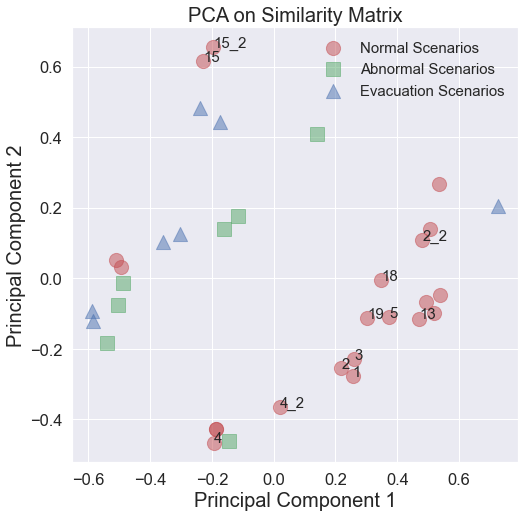

In [161]:
p = visualize_clusters(corr_mat, file_label_name, save=True)

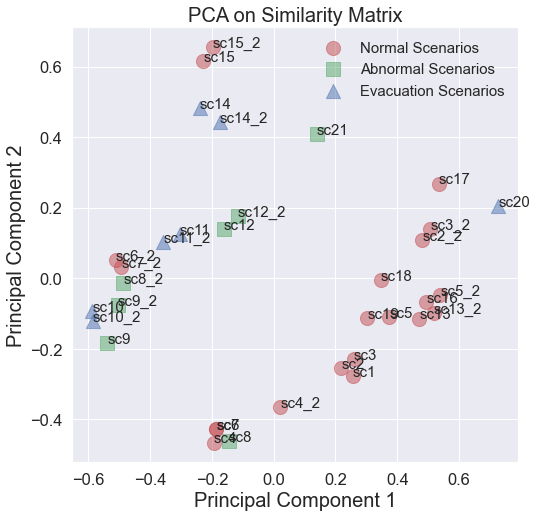

In [44]:
p = visualize_clusters(corr_mat, file_label_name, save=False)

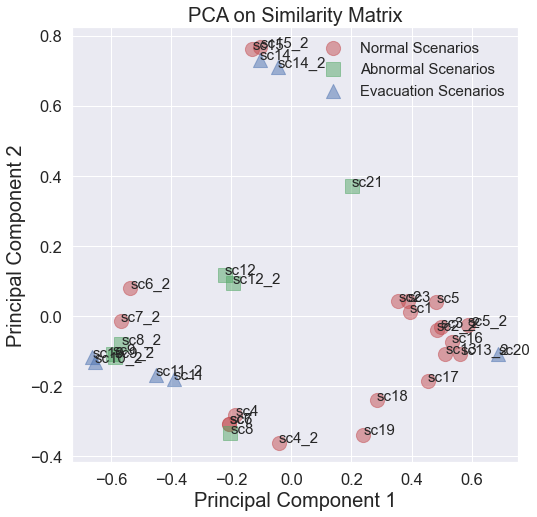

In [85]:
visualize_clusters(corr_mat, file_label_name, save=False) # data range

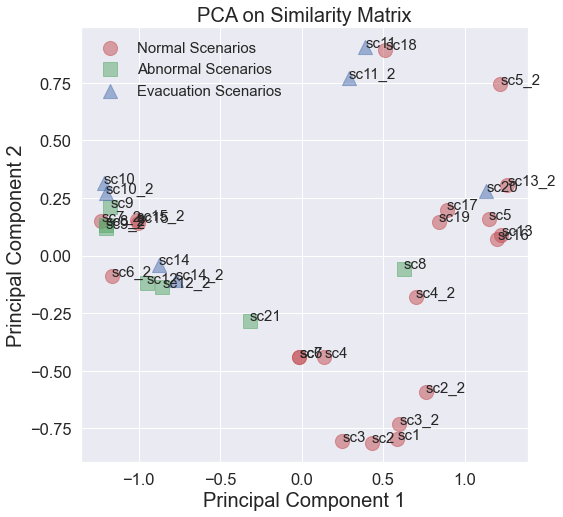

In [75]:
visualize_clusters(corr_mat, file_label_name, save=False) #normalized

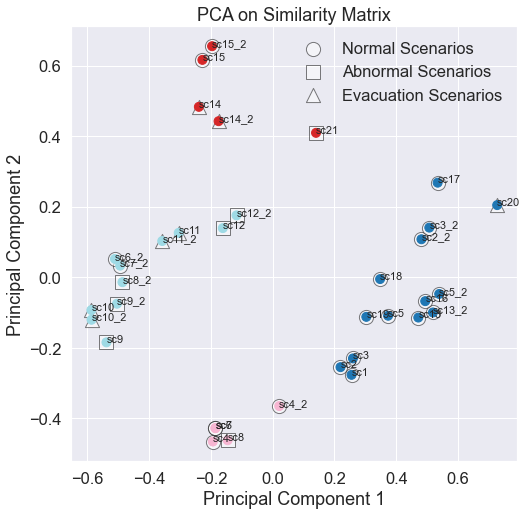

In [33]:
dend = visualize_clusters(corr_mat, file_label_name, n_clusters=4, mode="dend", save=False)

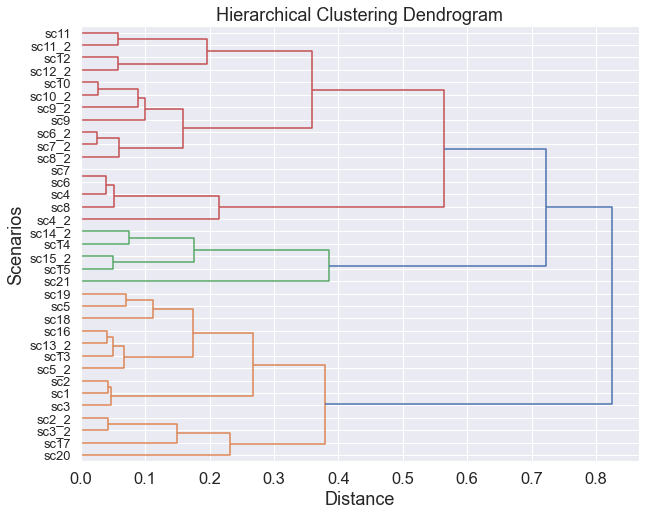

In [36]:
plot_dendrogram(dend, file_label_name)

(array([  6.,   6.,  16.,  22.,  76.,  78.,  96., 128., 132., 152., 102.,
         74.,  96.,  58.,  46.,  20.,  18.,  22.,  30.,  47.]),
 array([0.478 , 0.5041, 0.5302, 0.5563, 0.5824, 0.6085, 0.6346, 0.6607,
        0.6868, 0.7129, 0.739 , 0.7651, 0.7912, 0.8173, 0.8434, 0.8695,
        0.8956, 0.9217, 0.9478, 0.9739, 1.    ]),
 <BarContainer object of 20 artists>)

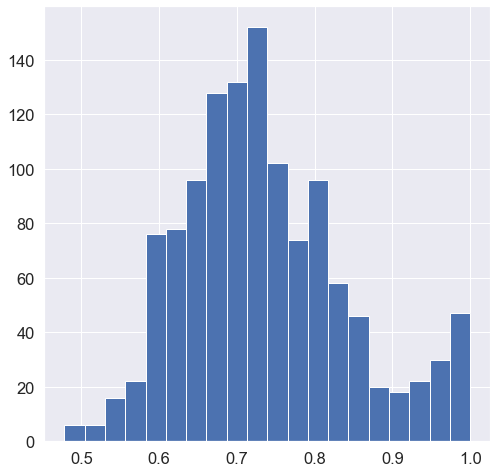

In [45]:
plt.hist(corr_mat.flatten(), bins=20)

In [156]:
from sklearn import preprocessing   

# min_max_scaler = preprocessing.MinMaxScaler()
#
# # X_minMax = min_max_scaler.fit_transform(B)
# X_minMax = B
# data = (X_minMax- X_minMax.min(axis=1).reshape(-1,1))/(X_minMax.max(axis=1).reshape(-1,1) - X_minMax.min(axis=1).reshape(-1,1))
# data = pd.DataFrame(data)
# sns.set(font_scale=1.5)
# sns.set_context({"figure.figsize":(8,8)})
# sns.heatmap(data=data,square=True)

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing   
import matplotlib.pyplot as plt

import numpy as np  
p1 = pd.read_table("raw_data/sc1/Rep1/AgentActivities.log", sep=';', header=0).dropna(axis=1, how='all')
p2 = pd.read_table("raw_data/sc2/Rep1/AgentActivities.log", sep=';', header=0).dropna(axis=1, how='all')
p3 = pd.read_table("raw_data/sc3/Rep1/AgentActivities.log", sep=';', header=0).dropna(axis=1, how='all')

def gen_od(df):
    shift_tab = df.sort_values(by="TimeIn", ascending=True).groupby(by="AgentID")[["TimeIn", "ActivityID"]].shift(-1)
    orign_tab = df.copy()
    orign_tab["NextTimeIn"] = shift_tab["TimeIn"]
    orign_tab["NextActivity"] = shift_tab["ActivityID"]
    orign_tab = orign_tab.dropna(subset=["NextActivity"])
    orign_tab["OD"] = orign_tab.apply(lambda row: "|".join([str(row.ActivityID), str(row.NextActivity)]), axis=1)

    od_series = orign_tab.groupby("OD").size()
    od = [1, 2, 8, 9, 10, 11, 12, 13, 14, 15]
    # od = [1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 28, 29, 31, 32, 34, 36, 37, 38, 39, 41, 42, 45, 46, 47, 48, 49]
    od_mat = np.zeros([len(od), len(od)])
    for ind in od_series.index:
        o = int(float(ind.split('|')[0]))
        d = int(float(ind.split('|')[1]))
        if o in od and d in od:
            od_mat[od.index(o), od.index(d)] += od_series[ind]

    # min_max_scaler = preprocessing.MinMaxScaler()  
    data = od_mat
    # data = (od_mat - od_mat.min(ax÷is=1).reshape(-1,1))/(od_mat.max(axis=1).reshape(-1,1) - od_mat.min(axis=1).reshape(-1,1))
    return data
data1 = gen_od(p1)
data2 = gen_od(p2)
data3 = gen_od(p3)

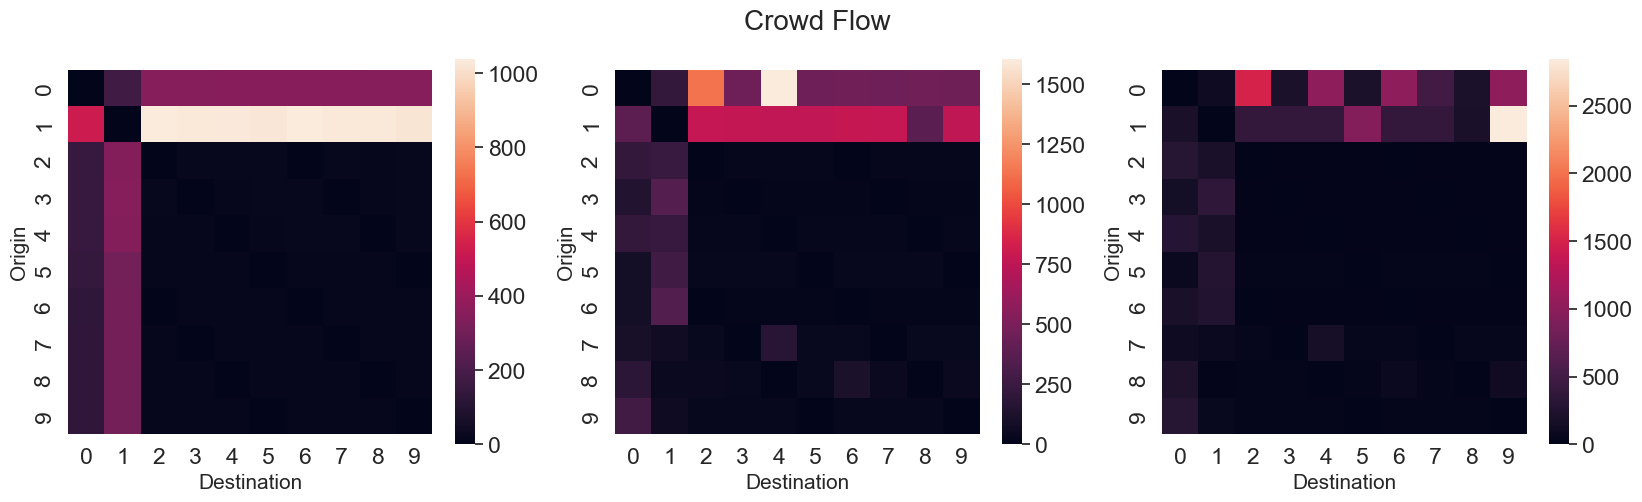

In [68]:
# p = pd.read_table("raw_data/Rep1/AgentActivities.log", sep=';', header=0).dropna(axis=1, how='all')

# data = pd.DataFrame(data)
# sns.set(font_scale=1.5)
sns.set_context({"figure.figsize":(20,5)})
f, (ax1, ax2, ax3) = plt.subplots(ncols=3)
sns.heatmap(data=data1,square=True, ax=ax1) 
sns.heatmap(data=data2,square=True, ax=ax2) 
sns.heatmap(data=data3,square=True, ax=ax3) 
# sns.heatmap(data=data3,square=True) 
f.suptitle('Crowd Flow',fontsize = 20) # title with fontsize 20
ax1.set_xlabel('Destination', fontsize = 15) # x-axis label with fontsize 15
ax1.set_ylabel('Origin', fontsize = 15) # y-axis label with fontsize 15
ax2.set_xlabel('Destination', fontsize = 15) # x-axis label with fontsize 15
ax2.set_ylabel('Origin', fontsize = 15) # y-axis label with fontsize 15
ax3.set_xlabel('Destination', fontsize = 15) # x-axis label with fontsize 15
ax3.set_ylabel('Origin', fontsize = 15) # y-axis label with fontsize 15

plt.show()
fig = f.get_figure()
fig.savefig("./fig/od_mat_notnor.pdf")

In [19]:
# activity = pd.read_table("raw_data/new_sc1/Rep1/ActivityLocations.log", sep=';', header=0).dropna(axis=1, how='all')
activity = pd.read_table("sc sensor 2/sc14/ActivityLocations.log", sep=';', header=0).dropna(axis=1, how='all')
activity.sort_values(by="ID")

,ID,ActivityName,ActivityGroup,ActivityType,ActivityTypeName,LayerID
21,1,Entry_exit_back,station_entry_exit,6001,Entry_Exit,1
9,2,Entry_exit_main,station_entry_exit,6001,Entry_Exit,1
11,8,Entry_exit_pl_1,platform_entry_exit_1,6001,Entry_Exit,2
13,9,Entry_exit_pl_3,platform_entry_exit_3,6001,Entry_Exit,2
30,10,Entry_exit_pl_5,platform_entry_exit_5,6001,Entry_Exit,2
37,11,Entry_exit_pl_7,platform_entry_exit_7,6001,Entry_Exit,2
36,12,Entry_exit_pl_2,platform_entry_exit_2,6001,Entry_Exit,2
22,13,Entry_exit_pl_4,platform_entry_exit_4,6001,Entry_Exit,2
35,14,Entry_exit_pl_6,platform_entry_exit_6,6001,Entry_Exit,2
6,15,Entry_exit_pl_8,platform_entry_exit_8,6001,Entry_Exit,2


In [9]:
import skmob

In [64]:
p = pd.read_table("raw_data/sc1/Rep1/AgentActivities.log", sep=';', header=0).dropna(axis=1, how='all')

In [2]:
import matplotlib.pyplot as plt


In [82]:
x = p[(p["zLoc"]==0)]["xLoc"].values
y = p[(p["zLoc"]==0)]["yLoc"].values

In [95]:
x2 = p[(p["zLoc"]==0) & (p["ActivityID"]==31)]["xLoc"].values
y2 = p[(p["zLoc"]==0) & (p["ActivityID"]==31)]["yLoc"].values
x1 = p[(p["zLoc"]==0) & (p["ActivityID"]==42)]["xLoc"].values
y1 = p[(p["zLoc"]==0) & (p["ActivityID"]==42)]["yLoc"].values
x3 = p[(p["zLoc"]==0) & (p["ActivityID"]==38)]["xLoc"].values
y3 = p[(p["zLoc"]==0) & (p["ActivityID"]==38)]["yLoc"].values

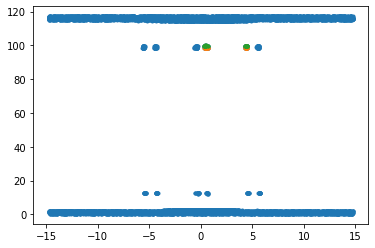

In [97]:
plt.plot(x, y, '.')
# plt.plot(x1, y1, '.')
plt.plot(x2, y2, '.')
plt.plot(x3, y3, '.')
plt.show()

## Explanation

In [ ]:
from xgboost import plot_importance
import  xgboost as xgb
import pickle

xgb_model = xgb.Booster()
if mode == "Insample":
    xgb_model.load_model('./result/boost/xgb_regressor.model')
elif mode == "OOD":
    xgb_model.load_model('./result/boost/xgb_regressor_ood.model')
else:
    pass
# plot_importance(xgb_model, max_num_features=10)

if mode == "Insample":
    mlp_model = pickle.load(open('./result/mlp/MLP.sav', 'rb'))
else:
    mlp_model = pickle.load(open('./result/mlp/MLP_ood.sav', 'rb'))
import lime
from lime import lime_tabular

train_X = data['x_train'].astype("float64")[:, -12:,:,:].reshape([-1, 12*args.features * args.num_nodes])
# test_X = data['x_test'].astype("float64")[:, -12:,:,:].reshape([-1, 12*args.features * args.num_nodes])
col_name = [f"step{i}_node{j+1}_feature{k}" for i in range(12, 0, -1) for j in range(35) for k in range(3)]
vis_data = data_dict["./sc sensor 2/sc17"].astype("float64") # after sliding window
source, target = sliding_win(vis_data)  # process data into continuous sample data
for i in range(3): #3 feature num
    source[..., i] = data["scalers"][i].transform(source[..., i])  # input data [N, seq_len, nodes, features]
    target[..., i] = data["scalers"][i].transform(target[..., i])  # ground truth
explainer = lime_tabular.LimeTabularExplainer(train_X, feature_names=col_name, mode="regression")
explainer

In [ ]:
idx = 10
##inverse transform mlp_model.predict

pred = mlp_model.predict(source.reshape(-1, num_nodes * output_dim * seq_len))
# for i in range(3):
#     pred[..., i] = data["scalers"][i].inverse_transform(pred[..., i])  # input data
print("Prediction : ", pred.reshape(-1, num_nodes * output_dim * seq_len)[idx])

print("Actual :     ", target.reshape(-1, num_nodes * output_dim * seq_len)[idx])
# explanation = explainer.explain_instance(xgb.DMatrix(source.reshape(-1, num_nodes * output_dim * seq_len)[idx][np.newaxis, :]), xgb_model.predict, num_features=10)
explanation = explainer.explain_instance(source.reshape(-1, num_nodes * output_dim * seq_len)[idx], mlp_model.predict, labels=[1], num_features=10)
explanation

In [ ]:
explanation.show_in_notebook(show_table=True)

In [ ]:
import matplotlib.pyplot as plt
with plt.style.context("ggplot"):
    explanation.as_pyplot_figure()